In [1]:
import lmdb
import torch
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
import time
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
# dataset = SinglePointLmdbDataset({"src": "train/"})
# len(dataset)
# datasets = {
# 'train_10k': '../10k/train/data.lmdb',
# 'train_100k': '../100k/train/data.lmdb',
# 'train_all': '../all/train/data.lmdb',
# 'val_id': '../all/val_id/data.lmdb',
# 'val_ood_ads': '../all/val_ood_ads/data.lmdb'
##  continue
# `data/is2re/all/val_ood_cat/data.lmdb`
# `data/is2re/all/val_ood_both/data.lmdb`
# `data/is2re/all/test_id/data.lmdb`
# `data/is2re/all/test_ood_ads/data.lmdb`
# `data/is2re/all/test_ood_cat/data.lmdb`
# `data/is2re/all/test_ood_both/data.lmdb`

In [2]:
dataset_train_10k = SinglePointLmdbDataset({"src": "train_test/data_copy.lmdb"})
dataset_train_all = SinglePointLmdbDataset({"src": "../all/test_ood_cat/data.lmdb"})
dataset_test_id = SinglePointLmdbDataset({"src": "../all/test_id/data.lmdb"})
dataset_val_ood_both = SinglePointLmdbDataset({"src": "../all/val_ood_both/data.lmdb"})

In [8]:
dataset_val_id = SinglePointLmdbDataset({"src": "../all/val_id/data.lmdb"})

In [10]:
len(dataset_test_id)

24948

In [9]:
len(dataset_val_id)

24943

In [7]:
len(dataset_val_ood_both)

24987

In [ ]:
from multiprocessing import Pool
def natom_hist(dataset):
    from collections import defaultdict
    import pandas as pd
    sec = time.time()
    dic = defaultdict(int)
    for struct in dataset:
        dic[struct.natoms] += 1
    print(time.time() - sec)

    dic_mod = {k:[v] for k,v in dict(dic).items()}
    return pd.DataFrame.from_dict(dic_mod, orient='index', columns=['N']).sort_index()

In [204]:
def df_distr(dic):
    dic = pd.DataFrame.to_dict(dic)
    key = list(dic.keys())[0]
    dic1 = {key:{i:0 for i in range(1, 301)}}
    
    for k, v in dic[key].items():
        dic1[key][k] = v
    return pd.DataFrame.from_dict(dic1)

In [207]:
frames = (df_train_all, dataset_test_id_df, dataset_train_10k_df, dataset_val_ood_both_df)
frames_distr = [0]*len(frames)
for i, frame in enumerate(frames):
    frames_distr[i] = df_distr(frame)

,N
1,0
2,0
3,0
4,0
5,0
6,0
7,9
8,7
9,120
10,75


<AxesSubplot:>

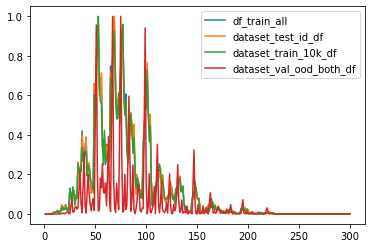

In [223]:
df_all = pd.concat(frames_distr, axis=1)
df_all.columns = ['df_train_all', 'dataset_test_id_df', 'dataset_train_10k_df', 'dataset_val_ood_both_df']
df_all_norm = df_all.fillna(0)
df_all_norm = df_all_norm.apply(lambda x: x / x.max())
df_all_norm.plot()

In [225]:
dataset_train_keys_10k_keys = set(dataset_train_10k[0].keys)
dataset_val_ood_both_keys = set(dataset_val_ood_both[0].keys)
dataset_test_keys_id_keys = set(dataset_test_id[0].keys)

In [229]:
print(dataset_train_keys_10k_keys, dataset_val_ood_both_keys, dataset_test_keys_id_keys, sep='\n')
print(dataset_train_keys_10k_keys - dataset_test_keys_id_keys)

{'edge_index', 'y_relaxed', 'y_init', 'sid', 'distances', 'pos', 'natoms', 'cell_offsets', 'pos_relaxed', 'fixed', 'force', 'tags', 'atomic_numbers', 'cell'}
{'edge_index', 'y_relaxed', 'y_init', 'sid', 'distances', 'pos', 'natoms', 'cell_offsets', 'pos_relaxed', 'fixed', 'force', 'tags', 'atomic_numbers', 'cell'}
{'edge_index', 'sid', 'pos', 'natoms', 'cell_offsets', 'fixed', 'tags', 'atomic_numbers', 'cell'}
{'y_relaxed', 'y_init', 'distances', 'pos_relaxed', 'force'}


In [ ]:
print(dataset_train_10k[0])
# for i in dataset_train_keys_10k_keys:
#         print((i, getattr(dataset_train_10k[0], i)))

for i in dataset_train_keys_10k_keys:
        temp = getattr(dataset_train_10k[0], i)
        print(i, temp)
#         if type(temp) not in [float, int]:
#             print(temp.shape)
#         else: print(temp)

In [250]:
dataset_train_10k[0].cell

tensor([[[ 1.1833e+01,  0.0000e+00, -2.6398e-02],
         [-3.0482e+00,  1.6439e+01, -1.1482e+00],
         [ 0.0000e+00,  0.0000e+00,  3.1385e+01]]])

In [222]:
from collections import Counter
# Counter(list(dataset_train_10k[0].atomic_numbers))
dataset_train_10k[0].atomic_numbers[0].item()
Counter([dataset_train_10k[0].atomic_numbers[i].item() for i in range(dataset_train_10k[0].atomic_numbers.shape[0])])
# compare = [("\n".join((getattr(dataset_train_10k[0], i), getattr(dataset_test[0], i)))) for i in dataset_test[0].keys]

NameError: name 'dataset_test' is not defined

In [112]:
dataset_train_10k[0].edge_index.shape

In [173]:
dataset_train_10k[0].natoms

86

In [113]:
86**2/2

3698.0

In [114]:
print(dataset_train_10k[0])

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [ ]:
import pandas as pd

dic = pd.read_pickle("/Users/korovin/Documents/GitHub/ocp_datasets/oc20_data_mapping.pkl")
# or use online https://dl.fbaipublicfiles.com/opencatalystproject/data/oc20_data_mapping.pkl

df = pd.DataFrame.from_dict(dic, orient='index')

In [246]:
df.head(10)

,bulk_id,ads_id,bulk_mpid,bulk_symbols,ads_symbols,miller_index,shift,top,adsorption_site
random2181546,6510,69,mp-22179,Si2Ti2Y2,*N2,"(2, 0, 1)",0.145,True,"((4.5, 12.85, 16.13),)"
random378384,2742,49,mp-9254,Al2Te5,*CHOCH2OH,"(0, 2, 1)",0.031,False,"((1.84, 6.17, 19.13),)"
random1283307,3219,30,mp-1226096,Co7Ge4,*CHO*CHO,"(0, 0, 1)",0.185,True,"((0.25, 2.07, 25.26), (1.25, 1.11, 24.84))"
random2061443,3381,79,mp-972941,Na2Bi6,*OHNH2,"(2, 1, 2)",0.050,False,"((6.22, 2.94, 26.1),)"
random2070408,2889,1,mp-1601,RuTa,*H,"(1, 1, 0)",0.250,True,"((7.58, 5.29, 19.72),)"
random2069970,7892,81,mp-567196,Cs3Sb2Cl9,*CN,"(1, 0, 1)",0.165,False,"((4.22, 1.86, 27.86),)"
random2426372,1431,60,mp-561320,Pb2S2,*OHNNCH3,"(2, 2, 1)",0.241,True,"((4.09, 21.6, 28.5),)"
random2049408,3760,56,mp-30933,Zr6Bi6,*CHOHCH2OH,"(0, 1, 0)",0.250,True,"((1.95, 2.21, 22.46),)"
random1170099,2302,73,mp-249,Al2Hf2,*NONH,"(2, 2, 1)",0.133,False,"((6.37, 4.22, 18.83),)"
random1530103,3589,73,mp-621624,Tl21Sb6,*NONH,"(2, 1, 0)",0.059,True,"((6.1, 2.21, 35.52),)"


In [248]:
df.loc['random2472718']

bulk_id                                425
ads_id                                  74
bulk_mpid                          mp-1791
bulk_symbols                       Al20Rh8
ads_symbols                            *NH
miller_index                     (2, 1, 1)
shift                                0.118
top                                   True
adsorption_site    ((10.07, 0.67, 18.05),)
Name: random2472718, dtype: object

In [249]:
import numpy as np
from mendeleev import element

def print_var_name(variable):
     for name in locals():
        if eval(name) == variable:
            print(name)

def getAtomSequence (sequence):
    result = list([[sequence[0], 1]])
    for i in range(1, len(sequence)):
        if sequence[i] == result[-1][0]:
            result[-1][1] += 1
        else:
            result.append([sequence[i], 1])
    return dict(result)

def structureToVASP(structure, file='POSCAR', str_name='structure', relaxed=False):
    with open(f'{str_name}_POSCAR{"_relaxed" if relaxed else ""}', 'w') as f:
        f.write(str_name + '\n')
        f.write(str(1.0) + '\n')
        for axis in np.array(structure.cell[0]):
            for i in range(3):
                f.write(str(axis[i]) + '   ')
                if i == 2:
                    f.write('\n')
        atoms = getAtomSequence(np.array(structure.atomic_numbers, dtype=int))
        for k in atoms.keys():
            f.write('   ' + element(round(k)).symbol)
        f.write('\n')
        for v in atoms.values():
            f.write('   ' + str(round(v)))
        f.write('\n')
        f.write('Cartesian\n')
        for position in np.array(structure.pos if not relaxed else structure.pos_relaxed):
            for i in range(3):
                f.write(str(position[i]) + '   ')
                if i == 2:
                    f.write('\n')          
    return None

for relaxed in [True, False] :
    structureToVASP(dataset_train_10k[0], relaxed=relaxed, str_name='dataset_train10k[0]')

In [164]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [167]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

sec = time.time()

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = Net()
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % int(200/10) == 0:
        print(epoch,':', time.time() - sec)

print('Total:', time.time() - sec)

model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))